# Initialize

In [6]:
!dpkg -i --force-depends --force-confnew /kaggle/input/pyvips-gpu/linux_packages/archives/*.deb 
!pip install pyvips -f /kaggle/input/pyvips-gpu/python_packages/ --no-index

Selecting previously unselected package apparmor.
(Reading database ... 114840 files and directories currently installed.)
Preparing to unpack .../apparmor_3.0.4-2ubuntu2.2_amd64.deb ...
Unpacking apparmor (3.0.4-2ubuntu2.2) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../autoconf_2.71-2_all.deb ...
Unpacking autoconf (2.71-2) ...
Selecting previously unselected package automake.
Preparing to unpack .../automake_1%3a1.16.5-1.3_all.deb ...
Unpacking automake (1:1.16.5-1.3) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../autotools-dev_20220109.1_all.deb ...
Unpacking autotools-dev (20220109.1) ...
Selecting previously unselected package bzip2-doc.
Preparing to unpack .../bzip2-doc_1.0.8-5build1_all.deb ...
Unpacking bzip2-doc (1.0.8-5build1) ...
Selecting previously unselected package file.
Preparing to unpack .../file_1%3a5.41-3ubuntu0.1_amd64.deb ...
Unpacking file (1:5.41-3ubuntu0.1) ...
Selecting previously unselected p

In [7]:
!pip install monai -f /kaggle/input/python-module-whl-files/Monai --no-index

Looking in links: /kaggle/input/python-module-whl-files/Monai
Processing /kaggle/input/python-module-whl-files/Monai/monai-0.9.1-202207251608-py3-none-any.whl


In [8]:
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models.resnet import ResNet
from torchvision.models.resnet import BasicBlock
from torchvision.models.resnet import Bottleneck
from typing import Optional, Union, List

In [9]:
import os, glob
import pyvips

import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import gc
#import segmentation_models_pytorch as smp

import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [10]:
import monai
from monai.inferers import SlidingWindowInferer, SimpleInferer
from monai.networks.nets import UNet
from torchvision.transforms import Compose, Resize, ToTensor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
Image.MAX_IMAGE_PIXELS = None

In [12]:
# Paths for the directories
parent_dir = '/kaggle/tmp/'
sub_dirs = ['CC', 'HGSC', 'LGSC', 'EC', 'MC']

# Create the parent directory if it doesn't exist
if not os.path.exists(parent_dir):
    os.makedirs(parent_dir)

# Now create the subdirectories
for sub_dir in sub_dirs:
    path = os.path.join(parent_dir, sub_dir)
    if not os.path.exists(path):
        os.makedirs(path)

# Get images

In [13]:
TRAIN_CSV_PATH = '/kaggle/input/UBC-OCEAN/train.csv'
TRAIN_IMAGES = '/kaggle/input/UBC-OCEAN/train_images'
TRAIN_THUMBNAILS = '/kaggle/input/UBC-OCEAN/train_thumbnails'

In [14]:
train_df = pd.read_csv(TRAIN_CSV_PATH)
train_df = train_df[train_df['is_tma'] != True]
train_df = train_df.drop(columns='is_tma')

In [15]:
def get_file_path(image_id, thumbnail=True):
    if thumbnail:
        return f"{TRAIN_THUMBNAILS}/{image_id}_thumbnail.png"
    else:
        return f"{TRAIN_IMAGES}/{image_id}.png"
    
    
train_df['thumbnail_path'] = train_df['image_id'].apply(get_file_path, thumbnail=True)
train_df['WS_path'] = train_df['image_id'].apply(get_file_path, thumbnail=False)

In [16]:
class UBCDataset(Dataset):
    def __init__(self, df, transform=None, thumbnail=True):
        self.df = df
        self.transform = transform
        self.thumbnail = thumbnail
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if self.thumbnail:
            img_path = self.df.iloc[idx]['thumbnail_path']
        else:
            img_path = self.df.iloc[idx]['WS_path']
        
        label = self.df.iloc[idx]['label']
        ID = self.df.iloc[idx]['image_id']
        
        img = pyvips.Image.new_from_file(img_path)
        
        if self.transform:
            img = self.transform(img.numpy())
            #img = torch.from_numpy(img.numpy())

        return img, label, ID

In [17]:
THUMBNAIL_IMAGE_SIZE = (1024, 1024)

In [18]:
thumbnail_transform = Compose([
    ToTensor(),
])

In [19]:
thumb_dataset = UBCDataset(df=train_df, transform=thumbnail_transform, thumbnail=True)
ws_dataset = UBCDataset(df=train_df, transform=None, thumbnail=False)

# Segment thumbnails

In [20]:
def patch_first_conv(model, new_in_channels, default_in_channels=3, pretrained=True):
    """Change first convolution layer input channels.
    In case:
        in_channels == 1 or in_channels == 2 -> reuse original weights
        in_channels > 3 -> make random kaiming normal initialization
    """

    # get first conv
    for module in model.modules():
        if isinstance(module, nn.Conv2d) and module.in_channels == default_in_channels:
            break

    weight = module.weight.detach()
    module.in_channels = new_in_channels

    if not pretrained:
        module.weight = nn.parameter.Parameter(
            torch.Tensor(module.out_channels, new_in_channels // module.groups, *module.kernel_size)
        )
        module.reset_parameters()

    elif new_in_channels == 1:
        new_weight = weight.sum(1, keepdim=True)
        module.weight = nn.parameter.Parameter(new_weight)

    else:
        new_weight = torch.Tensor(module.out_channels, new_in_channels // module.groups, *module.kernel_size)

        for i in range(new_in_channels):
            new_weight[:, i] = weight[:, i % default_in_channels]

        new_weight = new_weight * (default_in_channels / new_in_channels)
        module.weight = nn.parameter.Parameter(new_weight)

def replace_strides_with_dilation(module, dilation_rate):
    """Patch Conv2d modules replacing strides with dilation"""
    for mod in module.modules():
        if isinstance(mod, nn.Conv2d):
            mod.stride = (1, 1)
            mod.dilation = (dilation_rate, dilation_rate)
            kh, kw = mod.kernel_size
            mod.padding = ((kh // 2) * dilation_rate, (kh // 2) * dilation_rate)

            # Kostyl for EfficientNet
            if hasattr(mod, "static_padding"):
                mod.static_padding = nn.Identity()
                
class EncoderMixin:
    """Add encoder functionality such as:
    - output channels specification of feature tensors (produced by encoder)
    - patching first convolution for arbitrary input channels
    """

    _output_stride = 32

    @property
    def out_channels(self):
        """Return channels dimensions for each tensor of forward output of encoder"""
        return self._out_channels[: self._depth + 1]

    @property
    def output_stride(self):
        return min(self._output_stride, 2**self._depth)

    def set_in_channels(self, in_channels, pretrained=True):
        """Change first convolution channels"""
        if in_channels == 3:
            return

        self._in_channels = in_channels
        if self._out_channels[0] == 3:
            self._out_channels = tuple([in_channels] + list(self._out_channels)[1:])

        patch_first_conv(model=self, new_in_channels=in_channels, pretrained=pretrained)

    def get_stages(self):
        """Override it in your implementation"""
        raise NotImplementedError

    def make_dilated(self, output_stride):

        if output_stride == 16:
            stage_list = [
                5,
            ]
            dilation_list = [
                2,
            ]

        elif output_stride == 8:
            stage_list = [4, 5]
            dilation_list = [2, 4]

        else:
            raise ValueError("Output stride should be 16 or 8, got {}.".format(output_stride))

        self._output_stride = output_stride

        stages = self.get_stages()
        for stage_indx, dilation_rate in zip(stage_list, dilation_list):
            replace_strides_with_dilation(
                module=stages[stage_indx],
                dilation_rate=dilation_rate,
            )

In [21]:
class ResNetEncoder(ResNet, EncoderMixin):
    def __init__(self, out_channels, depth=5, **kwargs):
        super().__init__(**kwargs)
        self._depth = depth
        self._out_channels = out_channels
        self._in_channels = 3

        del self.fc
        del self.avgpool

    def get_stages(self):
        return [
            nn.Identity(),
            nn.Sequential(self.conv1, self.bn1, self.relu),
            nn.Sequential(self.maxpool, self.layer1),
            self.layer2,
            self.layer3,
            self.layer4,
        ]

    def forward(self, x):
        stages = self.get_stages()

        features = []
        for i in range(self._depth + 1):
            x = stages[i](x)
            features.append(x)

        return features

    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop("fc.bias", None)
        state_dict.pop("fc.weight", None)
        super().load_state_dict(state_dict, **kwargs)


new_settings = {
    "resnext50_32x4d": {
        "imagenet": "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth",
        "ssl": "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnext50_32x4-ddb3e555.pth",  # noqa
        "swsl": "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnext50_32x4-72679e44.pth",  # noqa
    },
}


resnet_encoders = {
    "resnext50_32x4d": {
        "encoder": ResNetEncoder,
        "pretrained_settings": None,
        "params": {
            "out_channels": (3, 64, 256, 512, 1024, 2048),
            "block": Bottleneck,
            "layers": [3, 4, 6, 3],
            "groups": 32,
            "width_per_group": 4,
        },
    },
}

In [22]:
encoders = {}
encoders.update(resnet_encoders)

def get_encoder(name, in_channels=3, depth=5, weights=None, output_stride=32, **kwargs):

    if name.startswith("tu-"):
        name = name[3:]
        encoder = TimmUniversalEncoder(
            name=name,
            in_channels=in_channels,
            depth=depth,
            output_stride=output_stride,
            pretrained=weights is not None,
            **kwargs,
        )
        return encoder

    try:
        Encoder = encoders[name]["encoder"]
    except KeyError:
        raise KeyError("Wrong encoder name `{}`, supported encoders: {}".format(name, list(encoders.keys())))

    params = encoders[name]["params"]
    params.update(depth=depth)
    encoder = Encoder(**params)

    if weights is not None:
        try:
            settings = encoders[name]["pretrained_settings"][weights]
        except KeyError:
            raise KeyError(
                "Wrong pretrained weights `{}` for encoder `{}`. Available options are: {}".format(
                    weights,
                    name,
                    list(encoders[name]["pretrained_settings"].keys()),
                )
            )
        encoder.load_state_dict(model_zoo.load_url(settings["url"]))

    encoder.set_in_channels(in_channels, pretrained=weights is not None)
    if output_stride != 32:
        encoder.make_dilated(output_stride)

    return encoder

In [23]:
class Conv2dReLU(nn.Sequential):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        padding=0,
        stride=1,
        use_batchnorm=True,
    ):

        if use_batchnorm == "inplace" and InPlaceABN is None:
            raise RuntimeError(
                "In order to use `use_batchnorm='inplace'` inplace_abn package must be installed. "
                + "To install see: https://github.com/mapillary/inplace_abn"
            )

        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        if use_batchnorm == "inplace":
            bn = InPlaceABN(out_channels, activation="leaky_relu", activation_param=0.0)
            relu = nn.Identity()

        elif use_batchnorm and use_batchnorm != "inplace":
            bn = nn.BatchNorm2d(out_channels)

        else:
            bn = nn.Identity()

        super(Conv2dReLU, self).__init__(conv, bn, relu)


class SCSEModule(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid(),
        )
        self.sSE = nn.Sequential(nn.Conv2d(in_channels, 1, 1), nn.Sigmoid())

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)

class ArgMax(nn.Module):
    def __init__(self, dim=None):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return torch.argmax(x, dim=self.dim)


class Clamp(nn.Module):
    def __init__(self, min=0, max=1):
        super().__init__()
        self.min, self.max = min, max

    def forward(self, x):
        return torch.clamp(x, self.min, self.max)


class Activation(nn.Module):
    def __init__(self, name, **params):

        super().__init__()

        if name is None or name == "identity":
            self.activation = nn.Identity(**params)
        elif name == "sigmoid":
            self.activation = nn.Sigmoid()
        elif name == "softmax2d":
            self.activation = nn.Softmax(dim=1, **params)
        elif name == "softmax":
            self.activation = nn.Softmax(**params)
        elif name == "logsoftmax":
            self.activation = nn.LogSoftmax(**params)
        elif name == "tanh":
            self.activation = nn.Tanh()
        elif name == "argmax":
            self.activation = ArgMax(**params)
        elif name == "argmax2d":
            self.activation = ArgMax(dim=1, **params)
        elif name == "clamp":
            self.activation = Clamp(**params)
        elif callable(name):
            self.activation = name(**params)
        else:
            raise ValueError(
                f"Activation should be callable/sigmoid/softmax/logsoftmax/tanh/"
                f"argmax/argmax2d/clamp/None; got {name}"
            )

    def forward(self, x):
        return self.activation(x)


class Attention(nn.Module):
    def __init__(self, name, **params):
        super().__init__()

        if name is None:
            self.attention = nn.Identity(**params)
        elif name == "scse":
            self.attention = SCSEModule(**params)
        else:
            raise ValueError("Attention {} is not implemented".format(name))

    def forward(self, x):
        return self.attention(x)

In [24]:
class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        use_batchnorm=True,
        attention_type=None,
    ):
        super().__init__()
        self.conv1 = Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention1 = Attention(attention_type, in_channels=in_channels + skip_channels)
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention2 = Attention(attention_type, in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x

class CenterBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        conv1 = Conv2dReLU(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        super().__init__(conv1, conv2)
        
class UnetDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels,
        decoder_channels,
        n_blocks=5,
        use_batchnorm=True,
        attention_type=None,
        center=False,
    ):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )

        # remove first skip with same spatial resolution
        encoder_channels = encoder_channels[1:]
        # reverse channels to start from head of encoder
        encoder_channels = encoder_channels[::-1]

        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels

        if center:
            self.center = CenterBlock(head_channels, head_channels, use_batchnorm=use_batchnorm)
        else:
            self.center = nn.Identity()

        # combine decoder keyword arguments
        kwargs = dict(use_batchnorm=use_batchnorm, attention_type=attention_type)
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch, **kwargs)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):

        features = features[1:]  # remove first skip with same spatial resolution
        features = features[::-1]  # reverse channels to start from head of encoder

        head = features[0]
        skips = features[1:]

        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)

        return x

In [25]:
def initialize_decoder(module):
    for m in module.modules():

        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight, mode="fan_in", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


def initialize_head(module):
    for m in module.modules():
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

class Activation(nn.Module):
    def __init__(self, name, **params):

        super().__init__()

        if name is None or name == "identity":
            self.activation = nn.Identity(**params)
        elif name == "sigmoid":
            self.activation = nn.Sigmoid()
        elif name == "softmax2d":
            self.activation = nn.Softmax(dim=1, **params)
        elif name == "softmax":
            self.activation = nn.Softmax(**params)
        elif name == "logsoftmax":
            self.activation = nn.LogSoftmax(**params)
        elif name == "tanh":
            self.activation = nn.Tanh()
        elif name == "argmax":
            self.activation = ArgMax(**params)
        elif name == "argmax2d":
            self.activation = ArgMax(dim=1, **params)
        elif name == "clamp":
            self.activation = Clamp(**params)
        elif callable(name):
            self.activation = name(**params)
        else:
            raise ValueError(
                f"Activation should be callable/sigmoid/softmax/logsoftmax/tanh/"
                f"argmax/argmax2d/clamp/None; got {name}"
            )

    def forward(self, x):
        return self.activation(x)


class SegmentationModel(torch.nn.Module):
    def initialize(self):
        initialize_decoder(self.decoder)
        initialize_head(self.segmentation_head)
        if self.classification_head is not None:
            initialize_head(self.classification_head)

    def check_input_shape(self, x):

        h, w = x.shape[-2:]
        output_stride = self.encoder.output_stride
        if h % output_stride != 0 or w % output_stride != 0:
            new_h = (h // output_stride + 1) * output_stride if h % output_stride != 0 else h
            new_w = (w // output_stride + 1) * output_stride if w % output_stride != 0 else w
            raise RuntimeError(
                f"Wrong input shape height={h}, width={w}. Expected image height and width "
                f"divisible by {output_stride}. Consider pad your images to shape ({new_h}, {new_w})."
            )

    def forward(self, x):
        """Sequentially pass `x` trough model`s encoder, decoder and heads"""

        self.check_input_shape(x)

        features = self.encoder(x)
        decoder_output = self.decoder(*features)

        masks = self.segmentation_head(decoder_output)

        if self.classification_head is not None:
            labels = self.classification_head(features[-1])
            return masks, labels

        return masks

    @torch.no_grad()
    def predict(self, x):
        """Inference method. Switch model to `eval` mode, call `.forward(x)` with `torch.no_grad()`

        Args:
            x: 4D torch tensor with shape (batch_size, channels, height, width)

        Return:
            prediction: 4D torch tensor with shape (batch_size, classes, height, width)

        """
        if self.training:
            self.eval()

        x = self.forward(x)

        return x
    
    
    
class SegmentationHead(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, activation=None, upsampling=1):
        conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        upsampling = nn.UpsamplingBilinear2d(scale_factor=upsampling) if upsampling > 1 else nn.Identity()
        activation = Activation(activation)
        super().__init__(conv2d, upsampling, activation)



class ClassificationHead(nn.Sequential):
    def __init__(self, in_channels, classes, pooling="avg", dropout=0.2, activation=None):
        if pooling not in ("max", "avg"):
            raise ValueError("Pooling should be one of ('max', 'avg'), got {}.".format(pooling))
        pool = nn.AdaptiveAvgPool2d(1) if pooling == "avg" else nn.AdaptiveMaxPool2d(1)
        flatten = nn.Flatten()
        dropout = nn.Dropout(p=dropout, inplace=True) if dropout else nn.Identity()
        linear = nn.Linear(in_channels, classes, bias=True)
        activation = Activation(activation)
        super().__init__(pool, flatten, dropout, linear, activation)


In [26]:
class Unet(SegmentationModel):
    """Unet_ is a fully convolution neural network for image semantic segmentation. Consist of *encoder*
    and *decoder* parts connected with *skip connections*. Encoder extract features of different spatial
    resolution (skip connections) which are used by decoder to define accurate segmentation mask. Use *concatenation*
    for fusing decoder blocks with skip connections.

    Args:
        encoder_name: Name of the classification model that will be used as an encoder (a.k.a backbone)
            to extract features of different spatial resolution
        encoder_depth: A number of stages used in encoder in range [3, 5]. Each stage generate features
            two times smaller in spatial dimensions than previous one (e.g. for depth 0 we will have features
            with shapes [(N, C, H, W),], for depth 1 - [(N, C, H, W), (N, C, H // 2, W // 2)] and so on).
            Default is 5
        encoder_weights: One of **None** (random initialization), **"imagenet"** (pre-training on ImageNet) and
            other pretrained weights (see table with available weights for each encoder_name)
        decoder_channels: List of integers which specify **in_channels** parameter for convolutions used in decoder.
            Length of the list should be the same as **encoder_depth**
        decoder_use_batchnorm: If **True**, BatchNorm2d layer between Conv2D and Activation layers
            is used. If **"inplace"** InplaceABN will be used, allows to decrease memory consumption.
            Available options are **True, False, "inplace"**
        decoder_attention_type: Attention module used in decoder of the model. Available options are
            **None** and **scse** (https://arxiv.org/abs/1808.08127).
        in_channels: A number of input channels for the model, default is 3 (RGB images)
        classes: A number of classes for output mask (or you can think as a number of channels of output mask)
        activation: An activation function to apply after the final convolution layer.
            Available options are **"sigmoid"**, **"softmax"**, **"logsoftmax"**, **"tanh"**, **"identity"**,
                **callable** and **None**.
            Default is **None**
        aux_params: Dictionary with parameters of the auxiliary output (classification head). Auxiliary output is build
            on top of encoder if **aux_params** is not **None** (default). Supported params:
                - classes (int): A number of classes
                - pooling (str): One of "max", "avg". Default is "avg"
                - dropout (float): Dropout factor in [0, 1)
                - activation (str): An activation function to apply "sigmoid"/"softmax"
                    (could be **None** to return logits)

    Returns:
        ``torch.nn.Module``: Unet

    .. _Unet:
        https://arxiv.org/abs/1505.04597

    """


    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: int = 5,
        encoder_weights: Optional[str] = "imagenet",
        decoder_use_batchnorm: bool = True,
        decoder_channels: List[int] = (256, 128, 64, 32, 16),
        decoder_attention_type: Optional[str] = None,
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, callable]] = None,
        aux_params: Optional[dict] = None,
    ):
        super().__init__()

        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
        )

        self.decoder = UnetDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=True if encoder_name.startswith("vgg") else False,
            attention_type=decoder_attention_type,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=classes,
            activation=activation,
            kernel_size=3,
        )

        if aux_params is not None:
            self.classification_head = ClassificationHead(in_channels=self.encoder.out_channels[-1], **aux_params)
        else:
            self.classification_head = None

        self.name = "u-{}".format(encoder_name)
        self.initialize()

In [27]:
ENCODER = 'resnext50_32x4d'
ENCODER_WEIGHTS = 'swsl'
CLASSES = 2
ACTIVATION = None  # could be None for logits or 'softmax2d' for multiclass segmentation
CHANNELS = (1024, 512, 256, 128, 64)
DEPTH = 5

model = Unet(
    encoder_name=ENCODER,
    encoder_weights=None,
    classes=CLASSES,
    activation=ACTIVATION,
    encoder_depth = DEPTH,
    decoder_channels =  CHANNELS,
)

In [28]:
checkpoint_path = '/kaggle/input/best-seg-model-v2-1/model_checkpoint_v2_1.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model'])
device = torch.device("cuda")
model = model.to(device)

In [24]:
img_idx = 5
org_image, label, img_id = thumb_dataset[img_idx]
print(img_id)

In [44]:


image = org_image.unsqueeze(0)

resize_down = Resize(THUMBNAIL_IMAGE_SIZE, antialias=True)
resize_up = Resize(image.shape[2:], antialias=True)

resized_img = resize_down(image)

model.eval()
with torch.no_grad():
    resized_img = resized_img.to(device)
    seg = model(resized_img)

seg_image = resize_up(seg)
seg_image = seg_image[0, 0].detach().cpu().numpy()

706


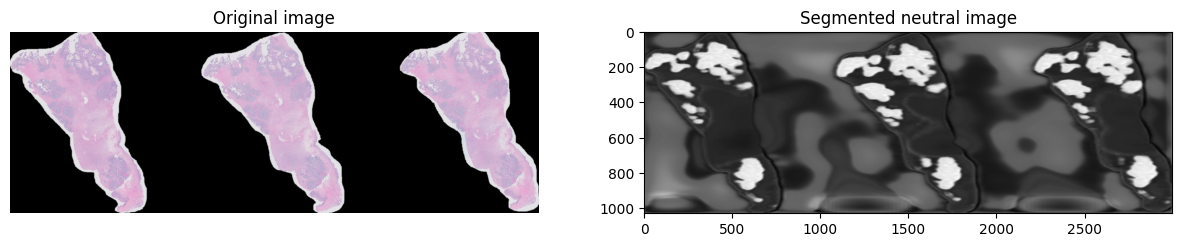

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5)) 

axs[0].imshow(org_image.permute(1, 2, 0))
axs[0].set_title('Original image')
axs[0].axis('off')

axs[1].imshow(seg_image, cmap='gray')
axs[1].set_title('Segmented neutral image')
#plt.savefig('segmentation.png')
plt.show()

# Extract promising tiles

In [29]:
import matplotlib.patches as patches
import heapq

In [30]:
TILE_SIZE = 1024
NUM_TILES = 50

In [31]:
def extract_top_tile_coords(heapmap, tile_size, num_tiles=100, thres_val=2):
    height, width = heapmap.shape
    heap = []

    for i in range(0, height - tile_size + 1, tile_size):
        for j in range(0, width - tile_size + 1, tile_size):
            tile = heapmap[i:i + tile_size, j:j + tile_size]
            score = np.sum(tile)  # You can adjust the scoring mechanism
            mean_value = np.mean(tile)

            # Check if the score is above the threshold and mean value is above 2
            if mean_value > thres_val:
                heapq.heappush(heap, (-score, (i, j)))

    # Trim the heap to get the top N tiles
    top_tiles_coords = [coords for _, coords in heapq.nsmallest(num_tiles, heap)]
    return top_tiles_coords

In [58]:
ws_image = ws_dataset[img_idx][0]
scale_factor=ws_image.width/image.shape[3]
thumbnail_tile_size=int(np.floor(TILE_SIZE/(scale_factor)))

tile_coords = extract_top_tile_coords(
    seg_image, 
    tile_size=thumbnail_tile_size, 
    num_tiles=NUM_TILES,
    thres_val=2)
len(tile_coords)

166

In [59]:
def plot_tiles_on_image(seg_prob, tile_coords, tile_size):
    fig, ax = plt.subplots()
    ax.imshow(seg_prob, cmap='gray')

    for i, j in tile_coords:
        rect = patches.Rectangle((j, i), tile_size, tile_size, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

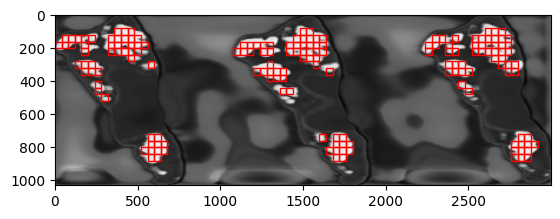

In [60]:
plot_tiles_on_image(seg_image, tile_coords, thumbnail_tile_size)

# Map to Whole Slide images

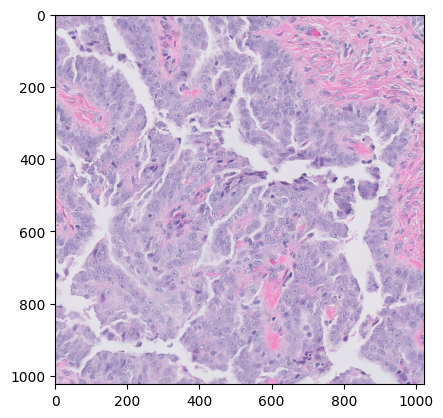

In [72]:
i, j = tile_coords[10]
I, J = int(i*scale_factor), int(j*scale_factor)
wstile = ws_image.crop(J, I, 1024, 1024).numpy()


plt.imshow(wstile)
plt.show()

# Putting it all together

In [33]:
pyvips.cache_set_max_files(1)
os.environ['VIPS_CONCURRENCY'] = '4'
os.environ['VIPS_DISC_THRESHOLD'] = '40gb'

In [32]:
def save_tile(tile, label, file_name):
    #tile = (tile.permute(1, 2, 0) * 255).detach().cpu().numpy().astype(np.uint8)
    #im = Image.fromarray(tile)

    if label == 'CC':
        label_folder = '/kaggle/tmp/CC/'
    elif label == 'HGSC':
        label_folder ='/kaggle/tmp/HGSC/'
    elif label == 'LGSC':
        label_folder ='/kaggle/tmp/LGSC/'
    elif label == 'EC':
        label_folder ='/kaggle/tmp/EC/'
    elif label == 'MC':
        label_folder ='/kaggle/tmp/MC/'
    
    
    filepath = os.path.join(label_folder, file_name)
    #im.save(filepath)
    tile.write_to_file(filepath)

In [34]:
def map_and_save_tiles(ws_image, tile_coords, scale_factor, label, ID, tile_size=224):
    for k, coord in enumerate(tqdm(tile_coords, desc="Mapping/saving tiles")):
        i, j = coord
        I, J = int(i*scale_factor), int(j*scale_factor)
        if I+tile_size<ws_image.height and J+tile_size<ws_image.width:
            tile = ws_image.crop(J, I, tile_size, tile_size)
            corners_px =[tile(0,0), tile(0,tile_size-1), tile(tile_size-1,0), tile(tile_size-1,tile_size-1)]
            
            if [0.0, 0.0, 0.0] not in corners_px and tile.avg()>40 and tile.avg()<215:
                save_tile(tile, label, file_name=f'im_{ID}_tile_{k}.png')

In [ ]:
#all_images=len(thumb_dataset)
resize_down = Resize(THUMBNAIL_IMAGE_SIZE, antialias=True)
for i in range(0, 513):
    org_image, label, ID = thumb_dataset[i]
    print(f"Processing thumbnail {ID}, {label} (iteration {i+1})")

    image = org_image.unsqueeze(0)

    resize_down = Resize(THUMBNAIL_IMAGE_SIZE, antialias=True)
    resize_up = Resize(image.shape[2:], antialias=True)

    resized_img = resize_down(image)
    model.eval()
    with torch.no_grad():
        resized_img = resized_img.to(device)
        seg = model(resized_img)

    seg_image = resize_up(seg)
    seg_image = seg_image[0, 0].detach().cpu().numpy()

    ws_image = ws_dataset[i][0]
    scale_factor=ws_image.width/image.shape[3]
    thumbnail_tile_size=int(np.floor(TILE_SIZE/(scale_factor)))

    tile_coords = extract_top_tile_coords(
        seg_image, 
        tile_size=thumbnail_tile_size, 
        num_tiles=NUM_TILES,
        thres_val=2)
    
    map_and_save_tiles(ws_image, tile_coords, scale_factor, label, ID, tile_size=TILE_SIZE)
    
    del image, label, ID, seg, seg_image, ws_image, scale_factor, thumbnail_tile_size, tile_coords
    gc.collect()

Processing thumbnail 31297, MC (iteration 251)


Mapping/saving tiles: 100%|██████████| 50/50 [01:57<00:00,  2.34s/it]  


Processing thumbnail 31300, LGSC (iteration 252)


Mapping/saving tiles: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Processing thumbnail 31333, HGSC (iteration 253)


Mapping/saving tiles: 100%|██████████| 50/50 [00:58<00:00,  1.16s/it]


Processing thumbnail 31383, EC (iteration 254)


Mapping/saving tiles: 100%|██████████| 50/50 [01:25<00:00,  1.72s/it] 


Processing thumbnail 31473, HGSC (iteration 255)


Mapping/saving tiles: 100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


Processing thumbnail 31793, LGSC (iteration 256)


Mapping/saving tiles: 100%|██████████| 21/21 [00:13<00:00,  1.59it/s]


Processing thumbnail 32032, CC (iteration 257)


Mapping/saving tiles: 100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


Processing thumbnail 32035, HGSC (iteration 258)


Mapping/saving tiles: 100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


Processing thumbnail 32042, EC (iteration 259)


Mapping/saving tiles: 100%|██████████| 50/50 [00:39<00:00,  1.28it/s]


Processing thumbnail 32112, HGSC (iteration 260)


Mapping/saving tiles: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


Processing thumbnail 32192, HGSC (iteration 261)


Mapping/saving tiles: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Processing thumbnail 32432, EC (iteration 262)


Mapping/saving tiles: 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


Processing thumbnail 32596, HGSC (iteration 263)


Mapping/saving tiles: 100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


Processing thumbnail 32636, EC (iteration 264)


Mapping/saving tiles: 100%|██████████| 50/50 [01:32<00:00,  1.85s/it] 


Processing thumbnail 33708, LGSC (iteration 265)


Mapping/saving tiles: 100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


Processing thumbnail 33839, LGSC (iteration 266)


Mapping/saving tiles: 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


Processing thumbnail 33976, LGSC (iteration 267)


Mapping/saving tiles: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Processing thumbnail 33984, EC (iteration 268)


Mapping/saving tiles: 100%|██████████| 50/50 [00:54<00:00,  1.08s/it]


Processing thumbnail 34247, HGSC (iteration 269)


Mapping/saving tiles: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


Processing thumbnail 34277, LGSC (iteration 270)


Mapping/saving tiles: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


Processing thumbnail 34508, MC (iteration 271)


Mapping/saving tiles: 100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


Processing thumbnail 34649, HGSC (iteration 272)


Mapping/saving tiles: 100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


Processing thumbnail 34688, LGSC (iteration 273)


Mapping/saving tiles: 100%|██████████| 50/50 [00:27<00:00,  1.82it/s]


Processing thumbnail 34690, EC (iteration 274)


Mapping/saving tiles: 100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


Processing thumbnail 34720, HGSC (iteration 275)


Mapping/saving tiles: 100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


Processing thumbnail 34822, EC (iteration 276)


Mapping/saving tiles: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


Processing thumbnail 34845, HGSC (iteration 277)


Mapping/saving tiles: 100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


Processing thumbnail 35197, CC (iteration 278)


Mapping/saving tiles: 100%|██████████| 50/50 [01:34<00:00,  1.89s/it] 


Processing thumbnail 35239, HGSC (iteration 279)


Mapping/saving tiles: 100%|██████████| 50/50 [01:35<00:00,  1.90s/it] 


Processing thumbnail 35592, HGSC (iteration 280)


Mapping/saving tiles: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


Processing thumbnail 35652, HGSC (iteration 281)


Mapping/saving tiles: 100%|██████████| 50/50 [01:36<00:00,  1.93s/it] 


Processing thumbnail 35754, EC (iteration 282)


Mapping/saving tiles: 100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


Processing thumbnail 35792, MC (iteration 283)


Mapping/saving tiles: 100%|██████████| 50/50 [01:50<00:00,  2.20s/it] 


Processing thumbnail 35909, EC (iteration 284)


Mapping/saving tiles: 100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


Processing thumbnail 35953, EC (iteration 285)


Mapping/saving tiles: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


Processing thumbnail 35998, HGSC (iteration 286)


Mapping/saving tiles: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


Processing thumbnail 36008, HGSC (iteration 287)


Mapping/saving tiles: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Processing thumbnail 36063, CC (iteration 288)


Mapping/saving tiles: 100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


Processing thumbnail 36204, HGSC (iteration 289)


Mapping/saving tiles: 100%|██████████| 50/50 [01:27<00:00,  1.74s/it] 


Processing thumbnail 36499, HGSC (iteration 290)


Mapping/saving tiles: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


Processing thumbnail 36513, HGSC (iteration 291)


Mapping/saving tiles: 100%|██████████| 50/50 [01:41<00:00,  2.04s/it] 


Processing thumbnail 36639, HGSC (iteration 292)


Mapping/saving tiles: 100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


Processing thumbnail 36678, MC (iteration 293)


Mapping/saving tiles: 100%|██████████| 50/50 [02:07<00:00,  2.55s/it]  


Processing thumbnail 37190, MC (iteration 294)


Mapping/saving tiles: 100%|██████████| 50/50 [01:56<00:00,  2.33s/it]  


Processing thumbnail 37307, MC (iteration 295)


Mapping/saving tiles: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Processing thumbnail 37367, HGSC (iteration 296)


Mapping/saving tiles: 100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


Processing thumbnail 37655, HGSC (iteration 297)


Mapping/saving tiles: 100%|██████████| 50/50 [01:21<00:00,  1.62s/it]


Processing thumbnail 38018, HGSC (iteration 298)


Mapping/saving tiles: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


Processing thumbnail 38019, MC (iteration 299)


Mapping/saving tiles: 100%|██████████| 50/50 [01:24<00:00,  1.68s/it]


Processing thumbnail 38041, HGSC (iteration 300)


Mapping/saving tiles: 100%|██████████| 50/50 [00:50<00:00,  1.00s/it]


Processing thumbnail 38048, HGSC (iteration 301)


Mapping/saving tiles: 100%|██████████| 50/50 [01:11<00:00,  1.44s/it]


Processing thumbnail 38097, HGSC (iteration 302)


Mapping/saving tiles: 100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


Processing thumbnail 38118, EC (iteration 303)


Mapping/saving tiles: 100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


Processing thumbnail 38349, CC (iteration 304)


Mapping/saving tiles: 100%|██████████| 50/50 [01:08<00:00,  1.38s/it]


Processing thumbnail 38366, LGSC (iteration 305)


Mapping/saving tiles: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Processing thumbnail 38479, EC (iteration 306)


Mapping/saving tiles: 100%|██████████| 50/50 [01:07<00:00,  1.36s/it]


Processing thumbnail 38535, HGSC (iteration 307)


Mapping/saving tiles: 100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


Processing thumbnail 38585, LGSC (iteration 308)


Mapping/saving tiles: 100%|██████████| 50/50 [00:56<00:00,  1.13s/it]


Processing thumbnail 38647, EC (iteration 309)


Mapping/saving tiles: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


Processing thumbnail 38669, CC (iteration 310)


Mapping/saving tiles: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Processing thumbnail 38687, CC (iteration 311)


Mapping/saving tiles: 100%|██████████| 18/18 [00:51<00:00,  2.88s/it]


Processing thumbnail 38849, LGSC (iteration 312)


Mapping/saving tiles: 100%|██████████| 50/50 [01:03<00:00,  1.26s/it]


Processing thumbnail 38901, EC (iteration 313)


Mapping/saving tiles: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Processing thumbnail 38959, LGSC (iteration 314)


Mapping/saving tiles: 100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


Processing thumbnail 39144, HGSC (iteration 315)


Mapping/saving tiles: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


Processing thumbnail 39146, HGSC (iteration 316)


Mapping/saving tiles: 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


Processing thumbnail 39172, HGSC (iteration 317)


Mapping/saving tiles: 100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


Processing thumbnail 39208, MC (iteration 318)


Mapping/saving tiles: 100%|██████████| 50/50 [00:56<00:00,  1.14s/it]


Processing thumbnail 39252, MC (iteration 319)


Mapping/saving tiles: 100%|██████████| 10/10 [01:00<00:00,  6.07s/it]


Processing thumbnail 39255, HGSC (iteration 320)


Mapping/saving tiles: 100%|██████████| 50/50 [01:41<00:00,  2.04s/it] 


Processing thumbnail 39258, LGSC (iteration 321)


Mapping/saving tiles: 100%|██████████| 50/50 [01:17<00:00,  1.56s/it]


Processing thumbnail 39269, EC (iteration 322)


Mapping/saving tiles: 100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


Processing thumbnail 39297, HGSC (iteration 323)


Mapping/saving tiles: 100%|██████████| 50/50 [01:10<00:00,  1.40s/it]


Processing thumbnail 39365, HGSC (iteration 324)


Mapping/saving tiles: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


Processing thumbnail 39425, HGSC (iteration 325)


Mapping/saving tiles: 100%|██████████| 50/50 [01:26<00:00,  1.73s/it] 


Processing thumbnail 39466, LGSC (iteration 326)


Mapping/saving tiles: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


Processing thumbnail 39728, HGSC (iteration 327)


Mapping/saving tiles: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Processing thumbnail 39872, MC (iteration 328)


Mapping/saving tiles: 100%|██████████| 13/13 [01:16<00:00,  5.90s/it]


Processing thumbnail 39880, CC (iteration 329)


Mapping/saving tiles: 100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


Processing thumbnail 39893, HGSC (iteration 330)


Mapping/saving tiles: 100%|██████████| 50/50 [01:39<00:00,  1.99s/it] 


Processing thumbnail 39990, HGSC (iteration 331)


Mapping/saving tiles: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Processing thumbnail 40079, EC (iteration 332)


Mapping/saving tiles: 100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Processing thumbnail 40124, EC (iteration 333)


Mapping/saving tiles: 100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


Processing thumbnail 40129, CC (iteration 334)


Mapping/saving tiles: 100%|██████████| 50/50 [00:51<00:00,  1.04s/it]


Processing thumbnail 40503, EC (iteration 335)


Mapping/saving tiles: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


Processing thumbnail 40639, HGSC (iteration 336)


Mapping/saving tiles: 100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Processing thumbnail 40888, CC (iteration 337)


Mapping/saving tiles: 100%|██████████| 50/50 [01:52<00:00,  2.26s/it] 


Processing thumbnail 41099, LGSC (iteration 338)


Mapping/saving tiles: 100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


Processing thumbnail 41361, HGSC (iteration 339)


Mapping/saving tiles: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


Processing thumbnail 41801, HGSC (iteration 340)


Mapping/saving tiles: 100%|██████████| 50/50 [01:53<00:00,  2.27s/it]  


Processing thumbnail 42125, CC (iteration 341)


Mapping/saving tiles: 100%|██████████| 50/50 [01:09<00:00,  1.38s/it]


Processing thumbnail 42260, MC (iteration 342)


Mapping/saving tiles: 100%|██████████| 50/50 [00:53<00:00,  1.06s/it]


Processing thumbnail 42296, CC (iteration 343)


Mapping/saving tiles: 100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


Processing thumbnail 42549, CC (iteration 344)


Mapping/saving tiles: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


Processing thumbnail 43280, EC (iteration 345)


Mapping/saving tiles: 100%|██████████| 50/50 [01:09<00:00,  1.40s/it]


Processing thumbnail 43390, HGSC (iteration 346)


Mapping/saving tiles: 100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


Processing thumbnail 43432, HGSC (iteration 347)


Mapping/saving tiles: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Processing thumbnail 43671, HGSC (iteration 348)


Mapping/saving tiles: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it]


Processing thumbnail 43796, CC (iteration 349)


Mapping/saving tiles: 100%|██████████| 50/50 [01:30<00:00,  1.82s/it] 


Processing thumbnail 43815, HGSC (iteration 350)


Mapping/saving tiles: 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]


Processing thumbnail 43875, HGSC (iteration 351)


Mapping/saving tiles: 100%|██████████| 50/50 [01:18<00:00,  1.56s/it]


Processing thumbnail 43998, EC (iteration 352)


Mapping/saving tiles: 100%|██████████| 50/50 [00:53<00:00,  1.08s/it]


Processing thumbnail 44232, EC (iteration 353)


Mapping/saving tiles: 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


Processing thumbnail 44283, CC (iteration 354)


Mapping/saving tiles: 100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


Processing thumbnail 44432, HGSC (iteration 355)


Mapping/saving tiles: 100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


Processing thumbnail 44530, MC (iteration 356)


Mapping/saving tiles: 100%|██████████| 50/50 [01:12<00:00,  1.46s/it]


Processing thumbnail 44581, CC (iteration 357)


Mapping/saving tiles: 100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Processing thumbnail 44700, EC (iteration 358)


Mapping/saving tiles: 100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


Processing thumbnail 44804, EC (iteration 359)


Mapping/saving tiles: 100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


Processing thumbnail 44962, EC (iteration 360)


Mapping/saving tiles: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


Processing thumbnail 44976, CC (iteration 361)


Mapping/saving tiles: 100%|██████████| 50/50 [00:56<00:00,  1.13s/it]


Processing thumbnail 45104, HGSC (iteration 362)


Mapping/saving tiles: 100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


Processing thumbnail 45185, HGSC (iteration 363)


Mapping/saving tiles: 100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


Processing thumbnail 45254, EC (iteration 364)


Mapping/saving tiles: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


Processing thumbnail 45578, EC (iteration 365)


Mapping/saving tiles: 100%|██████████| 50/50 [00:47<00:00,  1.04it/s]


Processing thumbnail 45630, EC (iteration 366)


Mapping/saving tiles: 100%|██████████| 50/50 [02:07<00:00,  2.55s/it]  


Processing thumbnail 45725, CC (iteration 367)


Mapping/saving tiles: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Processing thumbnail 45990, CC (iteration 368)


Mapping/saving tiles: 100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


Processing thumbnail 46139, HGSC (iteration 369)


Mapping/saving tiles: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


Processing thumbnail 46172, HGSC (iteration 370)


Mapping/saving tiles: 100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


Processing thumbnail 46435, HGSC (iteration 371)


Mapping/saving tiles: 100%|██████████| 50/50 [01:28<00:00,  1.77s/it] 


Processing thumbnail 46444, EC (iteration 372)


Mapping/saving tiles: 100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Processing thumbnail 46469, HGSC (iteration 373)


Mapping/saving tiles: 100%|██████████| 50/50 [01:43<00:00,  2.08s/it] 


Processing thumbnail 46543, CC (iteration 374)


Mapping/saving tiles: 100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


Processing thumbnail 46688, EC (iteration 375)


Mapping/saving tiles: 100%|██████████| 50/50 [01:27<00:00,  1.76s/it] 


Processing thumbnail 46736, HGSC (iteration 376)


Mapping/saving tiles: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


Processing thumbnail 46769, CC (iteration 377)


Mapping/saving tiles: 100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


Processing thumbnail 46793, HGSC (iteration 378)


Mapping/saving tiles: 100%|██████████| 50/50 [01:19<00:00,  1.58s/it]


Processing thumbnail 46815, MC (iteration 379)


Mapping/saving tiles: 100%|██████████| 50/50 [01:11<00:00,  1.42s/it]


Processing thumbnail 47020, HGSC (iteration 380)


Mapping/saving tiles: 100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


Processing thumbnail 47105, EC (iteration 381)


Mapping/saving tiles: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


Processing thumbnail 47431, MC (iteration 382)


Mapping/saving tiles: 100%|██████████| 28/28 [01:27<00:00,  3.14s/it]


Processing thumbnail 47837, HGSC (iteration 383)


Mapping/saving tiles: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Processing thumbnail 47911, HGSC (iteration 384)


Mapping/saving tiles: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


Processing thumbnail 47960, CC (iteration 385)


Mapping/saving tiles: 100%|██████████| 50/50 [01:28<00:00,  1.77s/it] 


Processing thumbnail 47984, HGSC (iteration 386)


Mapping/saving tiles: 100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Processing thumbnail 48502, MC (iteration 387)


Mapping/saving tiles: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Processing thumbnail 48506, CC (iteration 388)


Mapping/saving tiles: 100%|██████████| 50/50 [01:45<00:00,  2.11s/it] 


Processing thumbnail 48550, MC (iteration 389)


Mapping/saving tiles: 100%|██████████| 43/43 [00:37<00:00,  1.15it/s]


Processing thumbnail 48861, HGSC (iteration 390)


Mapping/saving tiles: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


Processing thumbnail 48973, HGSC (iteration 391)


Mapping/saving tiles: 100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


Processing thumbnail 49281, HGSC (iteration 392)


Mapping/saving tiles: 100%|██████████| 50/50 [01:09<00:00,  1.38s/it]


Processing thumbnail 49587, MC (iteration 393)


Mapping/saving tiles: 0it [00:00, ?it/s]


Processing thumbnail 49872, LGSC (iteration 394)


Mapping/saving tiles: 100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


Processing thumbnail 49942, EC (iteration 395)


Mapping/saving tiles: 100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


Processing thumbnail 49995, EC (iteration 396)


Mapping/saving tiles: 100%|██████████| 8/8 [00:16<00:00,  2.03s/it]


Processing thumbnail 50048, EC (iteration 397)


Mapping/saving tiles: 100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


Processing thumbnail 50246, EC (iteration 398)


Mapping/saving tiles: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


Processing thumbnail 50304, EC (iteration 399)


Mapping/saving tiles: 100%|██████████| 50/50 [01:43<00:00,  2.08s/it] 


Processing thumbnail 50589, HGSC (iteration 400)


Mapping/saving tiles: 100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


Processing thumbnail 50712, HGSC (iteration 401)


Mapping/saving tiles: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


Processing thumbnail 50878, HGSC (iteration 402)


Mapping/saving tiles: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


Processing thumbnail 50962, EC (iteration 403)


Mapping/saving tiles: 100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


Processing thumbnail 51021, HGSC (iteration 404)


Mapping/saving tiles: 100%|██████████| 50/50 [01:29<00:00,  1.80s/it] 


Processing thumbnail 51032, EC (iteration 405)


Mapping/saving tiles: 100%|██████████| 50/50 [01:31<00:00,  1.83s/it] 


Processing thumbnail 51128, EC (iteration 406)


Mapping/saving tiles: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


Processing thumbnail 51215, EC (iteration 407)


Mapping/saving tiles: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


Processing thumbnail 51346, CC (iteration 408)


Mapping/saving tiles: 100%|██████████| 50/50 [02:14<00:00,  2.69s/it]  


Processing thumbnail 51499, EC (iteration 409)


Mapping/saving tiles: 100%|██████████| 50/50 [00:54<00:00,  1.08s/it]


Processing thumbnail 51679, EC (iteration 410)


Mapping/saving tiles: 100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


Processing thumbnail 51832, HGSC (iteration 411)


Mapping/saving tiles: 100%|██████████| 50/50 [00:51<00:00,  1.04s/it]


Processing thumbnail 51893, MC (iteration 412)


Mapping/saving tiles: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


Processing thumbnail 52108, EC (iteration 413)


Mapping/saving tiles: 100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


Processing thumbnail 52259, CC (iteration 414)


Mapping/saving tiles: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Processing thumbnail 52275, HGSC (iteration 415)


Mapping/saving tiles: 100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


Processing thumbnail 52308, HGSC (iteration 416)


Mapping/saving tiles: 100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Processing thumbnail 52375, CC (iteration 417)


Mapping/saving tiles: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


Processing thumbnail 52420, CC (iteration 418)


Mapping/saving tiles: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


Processing thumbnail 52438, HGSC (iteration 419)


Mapping/saving tiles: 100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


Processing thumbnail 52461, CC (iteration 420)


Mapping/saving tiles: 100%|██████████| 47/47 [00:42<00:00,  1.09it/s]


Processing thumbnail 52612, LGSC (iteration 421)


Mapping/saving tiles: 100%|██████████| 50/50 [00:41<00:00,  1.19it/s]


Processing thumbnail 52752, EC (iteration 422)


Mapping/saving tiles:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
del image, label, ID, seg, seg_image, ws_image, scale_factor, thumbnail_tile_size, tile_coords
gc.collect()

In [42]:
def count_files_in_directory(directory):
    file_count = 0
    for root, dirs, files in os.walk(directory):
        file_count += len([file for file in files if os.path.isfile(os.path.join(root, file))])
    return file_count

directory_path = '/kaggle/tmp/'
total_files = count_files_in_directory(directory_path)
print(f"Total number of files in {directory_path}: {total_files}")


Total number of files in /kaggle/tmp/: 0


In [38]:
!zip -r tiles.zip /kaggle/tmp/

  adding: kaggle/tmp/ (stored 0%)
  adding: kaggle/tmp/CC/ (stored 0%)
  adding: kaggle/tmp/CC/im_17067_tile_47.png (deflated 0%)
  adding: kaggle/tmp/CC/im_30272_tile_35.png (deflated 0%)
  adding: kaggle/tmp/CC/im_24563_tile_9.png (deflated 0%)
  adding: kaggle/tmp/CC/im_24563_tile_25.png (deflated 0%)
  adding: kaggle/tmp/CC/im_24563_tile_2.png (deflated 0%)
  adding: kaggle/tmp/CC/im_15470_tile_17.png (deflated 0%)
  adding: kaggle/tmp/CC/im_17067_tile_24.png (deflated 0%)
  adding: kaggle/tmp/CC/im_30369_tile_40.png (deflated 0%)
  adding: kaggle/tmp/CC/im_18813_tile_42.png (deflated 0%)
  adding: kaggle/tmp/CC/im_26219_tile_29.png (deflated 0%)
  adding: kaggle/tmp/CC/im_16325_tile_38.png (deflated 0%)
  adding: kaggle/tmp/CC/im_29915_tile_30.png (deflated 0%)
  adding: kaggle/tmp/CC/im_18014_tile_31.png (deflated 0%)
  adding: kaggle/tmp/CC/im_24563_tile_28.png (deflated 0%)
  adding: kaggle/tmp/CC/im_29615_tile_40.png (deflated 0%)
  adding: kaggle/tmp/CC/im_17067_tile_21.png (

In [39]:
from IPython.display import FileLink
FileLink(r'tiles.zip')

/kaggle/working/tiles.zip

In [40]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/tmp/'
remove_folder_contents(folder_path)

In [41]:
# Paths for the directories
parent_dir = '/kaggle/tmp/'
sub_dirs = ['CC', 'HGSC', 'LGSC', 'MC', 'EC']

# Create the parent directory if it doesn't exist
if not os.path.exists(parent_dir):
    os.makedirs(parent_dir)

# Now create the subdirectories
for sub_dir in sub_dirs:
    path = os.path.join(parent_dir, sub_dir)
    if not os.path.exists(path):
        os.makedirs(path)

In [60]:
os.unlink('/kaggle/working/tiles.zip')